In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU


In [18]:
# 1. Cargar el archivo
# Indicamos que la columna 'timestamp' debe ser parseada como fecha.
try:
    df = pd.read_csv("btc_data.csv", parse_dates=['timestamp'])
except FileNotFoundError:
    print("Error: Asegúrate de que 'btc_data.csv' esté en el mismo directorio.")
    exit()

# 2. Establecer 'timestamp' como índice (fundamental para series temporales)
df = df.set_index('timestamp')



def analizar_y_graficar_df(df: pd.DataFrame, titulo_grafico: str = 'Precio de Cierre (Serie Temporal)'):
    print("--- Información del DataFrame ---")
    df.info()
    print("\nPrimeros registros:")
    print(df.head())
    print("---------------------------------")
    
    if 'close' in df.columns:
        plt.figure(figsize=(14, 6))
        # Graficamos el precio de cierre
        df['close'].plot(title=titulo_grafico, grid=True)
        plt.xlabel("Índice/Fecha") # Usamos 'Índice/Fecha' ya que no sabemos si el índice es datetime
        plt.ylabel("Precio (USD)")
        plt.show()
    else:
        print("\n Advertencia: La columna 'close' no se encontró en el DataFrame para graficar.")

# Ejemplo de recorte: Iniciar desde Enero de 2020
df_recortado = df.loc['2020-01-01':]
#print(f"Dataset recortado, ahora inicia en: {df_recortado.index.min()}")

#analizar_y_graficar_df(df_recortado, titulo_grafico='Precio de Cierre de Bitcoin desde 2020')
# Remuestreo a Datos Diarios ('D')
df_diario = df_recortado.resample('D').agg({
    'open': 'first',      # Primer precio del día es el Open
    'high': 'max',        # Máximo precio del día
    'low': 'min',         # Mínimo precio del día
    'close': 'last',      # Último precio del día es el Close
    'volume': 'sum'       # Suma de volumen de todo el día
}).dropna() # Eliminamos días donde no hubo trading



# Remuestreo a Datos por hora ('h')
df_porHora = df_recortado.resample('h').agg({
    'open': 'first',      # Primer precio del día es el Open
    'high': 'max',        # Máximo precio del día
    'low': 'min',         # Mínimo precio del día
    'close': 'last',      # Último precio del día es el Close
    'volume': 'sum'       # Suma de volumen de todo el día
}).dropna() # Eliminamos días donde no hubo trading




In [19]:
punto_corte = '2025-01-01'

df_train_val = df_diario.loc[:punto_corte].iloc[:-1] # Hasta antes de 2025-01-01
df_test_final = df_diario.loc[punto_corte:]       # Desde 2025-01-01 en adelante  

#Escalado y Normalización (MinMaxScaler)
df_train_val['volatilidad'] = df_train_val['high'] - df_train_val['low']    # 1. Crear la característica de Volatilidad (High - Low)

#analizar_y_graficar_df(df_train_val, titulo_grafico='Precio de Bitcoin desde 2020 hasta 2025')

features = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']    # 2. Seleccionar las columnas que vamos a usar como características (features)
data = df_train_val[features].values    # Es mejor usar Open, High, Low, Close, Volume, y la Volatilidad que creamos.  
                                        # Convertir a array de NumPy

scaler = MinMaxScaler(feature_range=(0, 1))     # 3. Inicializar y Ajustar el Escalador (SOLO en los datos de entrenamiento)
scaled_data = scaler.fit_transform(data)

# Definir la ventana de tiempo (timestep)
TIMESTEP = 60

# Listas para almacenar las secuencias
X_train = []
Y_train = []

# Iterar sobre el array escalado para crear las secuencias
for i in range(TIMESTEP, len(scaled_data)):
    # X_train contendrá los 60 valores anteriores (días i-60 hasta i-1)
    X_train.append(scaled_data[i-TIMESTEP:i, :]) 
    
    # Y_train contendrá el precio de CIERRE del día actual (día i). 
    # El precio de cierre es la 4ta columna (índice 3) en nuestra lista 'features'.
    Y_train.append(scaled_data[i, features.index('close')])

# Convertir las listas a arreglos de NumPy
X_train, Y_train = np.array(X_train), np.array(Y_train)


#Modelo LSTM:
# Una capa recurrente con 50 unidades
# Una capa de Dropout para prevenir el sobreajuste.
# Una capa Densa (Dense) de salida con 1 unidad, 
#       utilizando activación lineal, ya que es una tarea de regresión 
#       (prediciendo un valor continuo: el precio).

def crear_modelo_lstm(input_shape):
    """Define y compila el modelo LSTM."""
    
    # El input_shape debe ser (TIMESTEP, features) -> (60, 6)
    model = Sequential()
    
    # Capa LSTM
    model.add(LSTM(
        units=50, 
        return_sequences=False, # False porque solo nos interesa la salida del último paso de tiempo
        input_shape=input_shape
    ))
    
    # Capa de Dropout (para regularización)
    model.add(Dropout(0.2))
    
    # Capa de Salida (Predicción de 1 valor: Precio de Cierre)
    model.add(Dense(units=1))
    
    # Compilación: Usamos 'adam' como optimizador y 'mean_squared_error' (MSE) como métrica
    # MSE es común en tareas de regresión.
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

#Modelo GRU

def crear_modelo_gru(input_shape):
    """Define y compila el modelo GRU."""
    
    model = Sequential()
    
    # Capa GRU
    model.add(GRU(
        units=50, 
        return_sequences=False, 
        input_shape=input_shape
    ))
    
    # Capa de Dropout
    model.add(Dropout(0.2))
    
    # Capa de Salida
    model.add(Dense(units=1))
    
    # Compilación
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model


#Entrenamiento y Comparación Inicial

# Definir la forma de entrada: (Timesteps, Features)
# En este caso: (60, 6)
input_shape = (X_train.shape[1], X_train.shape[2]) 

# 1. Crear Modelos
modelo_lstm = crear_modelo_lstm(input_shape)
#modelo_gru = crear_modelo_gru(input_shape)

print("--- Resumen del Modelo LSTM ---")
modelo_lstm.summary()

#print("\n--- Resumen del Modelo GRU ---")
#modelo_gru.summary()

print("\n--- Iniciando Entrenamiento LSTM ---")
history_lstm = modelo_lstm.fit(
    X_train, 
    Y_train, 
    epochs=25,        # Número de pasadas de entrenamiento
    batch_size=32,    # Tamaño de lote
    validation_split=0.2, 
    verbose=1
)



--- Resumen del Modelo LSTM ---


C:\Users\crges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando Entrenamiento LSTM ---
Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0010 - val_loss: 8.9124e-04
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.5345e-04 - val_loss: 8.5633e-04
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.6975e-04 - val_loss: 0.0016
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.6864e-04 - val_loss: 8.3882e-04
Epoch 9/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1582e-04 - val_loss: 0.0020
Epoch 10/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.5767e-04 - val_loss: 0.0021
Epoch 11/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.2545e-04 - val_lo


Forma de X_test (muestras de 2025, 60, 6): (267, 60, 6)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


C:\Users\crges\AppData\Local\Temp\ipykernel_15704\2173064704.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']


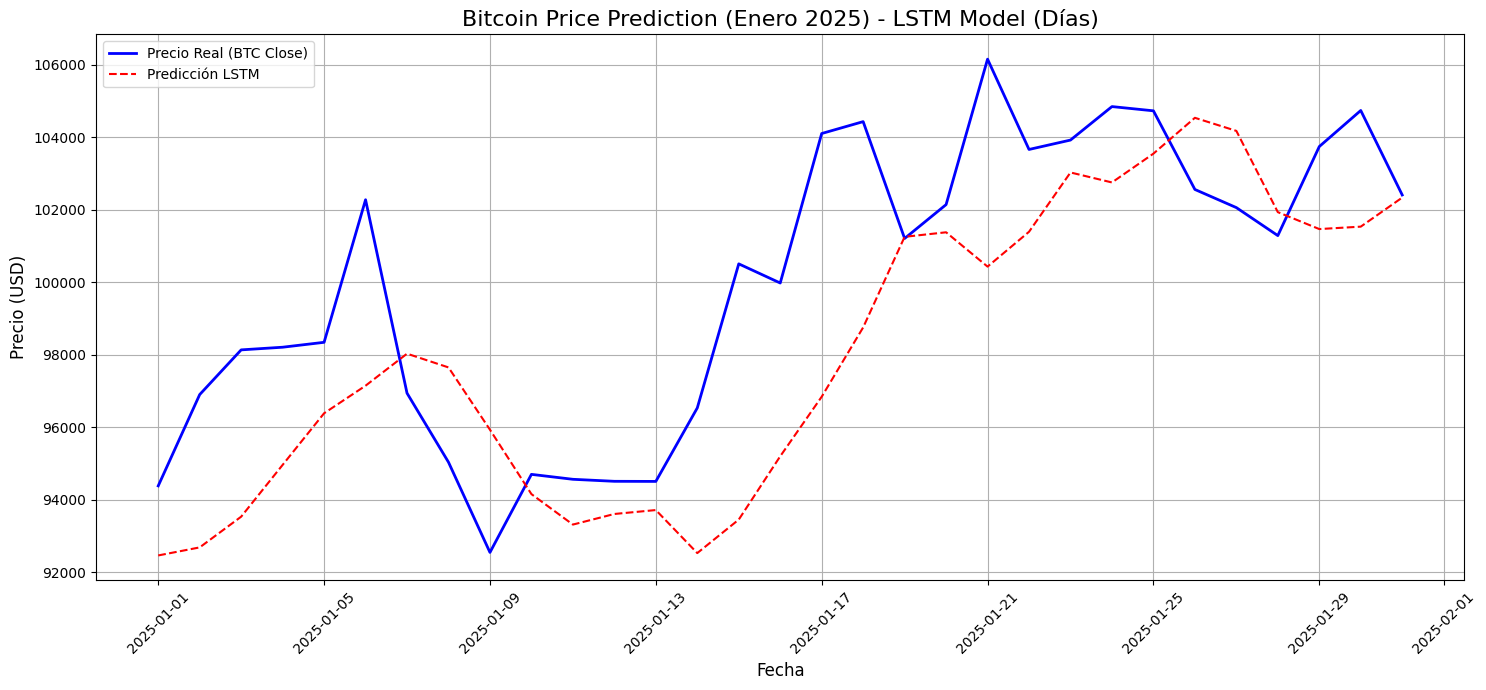

In [30]:
#df_test_final
#analizar_y_graficar_df(df_test_final, titulo_grafico='Datos - Cotización 2025')

df_diciembre_24 = df_train_val.loc['2024-12-01':'2024-12-31']
#analizar_y_graficar_df(df_diciembre_24, titulo_grafico='Datos - Diciembre 2024')


df_enero_25 = df_test_final.loc['2025-01-01':'2025-01-31']       # Desde 2025-01-01 en adelante  
#analizar_y_graficar_df(df_enero_25, titulo_grafico='Datos - Enero 2025')



#   1)Preparar los datos de 2025: Deben tener exactamente el mismo formato  
#               (escalado, ventana de 60 días) que los datos de entrenamiento.


#Crear la característica de Volatilidad en el dataset final también
df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']

# Concatenamos el final de df_train_val con df_test_final
# Esto es necesario para poder crear la primera ventana de 60 días en el set de testeo.
# Usamos los 60 días anteriores al inicio de 2025.
dataset_completo = pd.concat((df_train_val[features].iloc[-TIMESTEP:], df_test_final[features]), axis=0)

# Escalamos el conjunto completo de prueba usando el *mismo* escalador ajustado ANTES.
# ¡Importante!: Usamos scaler.transform(), NUNCA scaler.fit_transform() aquí.
data_test = dataset_completo[features].values
scaled_test_data = scaler.transform(data_test)

# Creamos la estructura X_test (secuencias de 60 días)
X_test = []
# Iteramos SÓLO sobre la longitud del dataset final
for i in range(TIMESTEP, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-TIMESTEP:i, :])

X_test = np.array(X_test)

print(f"\nForma de X_test (muestras de 2025, 60, 6): {X_test.shape}")


#   2)Predecir: Pasar estos datos al modelo (modelo_lstm.predict()).
# Generamos las predicciones escaladas (entre 0 y 1)
predictions_scaled = modelo_lstm.predict(X_test)


#   3)Desescalar: Convertir la predicción (que está entre 0 y 1) de vuelta a precios reales en dólares.
# 1. Crear un array fantasma para el desescalado
# El array debe tener la forma (Número de predicciones, Número de Features) -> (N, 6)
dummy_array = np.zeros(shape=(len(predictions_scaled), len(features)))

# 2. Colocar las predicciones escaladas en la columna de 'close' (índice 3)
close_idx = features.index('close')
dummy_array[:, close_idx] = predictions_scaled[:, 0]

# 3. Desescalar todo el array fantasma
predictions_descaled = scaler.inverse_transform(dummy_array)

# 4. Obtener las predicciones reales (solo la columna 'close')
precios_predichos_reales = predictions_descaled[:, close_idx]

#print("\n--- Resultados de la Predicción ---")
#print(f"Predicciones desescaladas (precios reales en USD): {precios_predichos_reales[:5]}")
#print(f"Predicciones desescaladas (precios reales en USD): {precios_predichos_reales[:31]}")

# 1. Obtener el array de precios reales
# El precio de cierre es la columna 'close'.
precios_reales = df_test_final['close'].values

# 2. Recortar ambos arrays (Predichos y Reales) para Enero 2025
# Asumimos que la primera predicción corresponde al primer día de testeo (2025-01-01).
dias_de_enero = 31 

# Nota: X_test se construyó para tener la misma longitud que df_test_final,
# por lo que los precios predichos tienen la misma longitud.

precios_predichos_enero = precios_predichos_reales[:dias_de_enero]
precios_reales_enero = precios_reales[:dias_de_enero]

# 3. Obtener las fechas correspondientes para el eje X
fechas_enero = df_test_final.index[:dias_de_enero]


import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Gráfico de los precios reales
plt.plot(fechas_enero, precios_reales_enero, label='Precio Real (BTC Close)', color='blue', linewidth=2)

# Gráfico de la predicción LSTM
plt.plot(fechas_enero, precios_predichos_enero, label='Predicción LSTM', color='red', linestyle='--', linewidth=1.5)

plt.title('Bitcoin Price Prediction (Enero 2025) - LSTM Model (Días)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45) # Rotar las etiquetas del eje X para mejor lectura
plt.tight_layout() # Ajusta el diseño para que todo quepa
plt.show()